In [1]:
import numpy as np
import matplotlib.pyplot as plt

from monte_carlo import ExactMCAgent, MCAgent, run_episode
from envs.gridworld import GridworldEnv
from utils.grid_visualization import visualize_value_function, visualize_policy

np.random.seed(0)

In [2]:
nx, ny = 4, 4
env = GridworldEnv([ny, nx])

## Monte-carlo '에이전트' 초기화하기

드디어 에이전트라고 부를 수 있는 것을 우리가 다루게 되었습니다. `ExacatMCAgent` 는 __"도박의 도시 몬테카를로 (MC) 그리고 MC 정책추정"__ 에서 배운 Vanilla 버전의 Monte-carlo 정책평가를 수행합니다. Vanilla MC policy evaluation은 다음과 같은 수식으로 상태 가치함수를 추산합니다.

$$ V(s) \leftarrow \frac{G(s)}{N(s)}$$
여기서, $G(s)$ 는 상태 $s$의 리턴 추산치의 합. $N(s)$ 는 상태 $s$의 방문 횟수.

또한, 우리가 평가하려는 정책은 행동 가치함수 $Q(s,a)$ 에 대한 '$\epsilon$-탐욕적 정책' 이라고 생각해보겠습니다. 이제 한번 파이썬 구현체를 살펴보도록 할까요?

```python
class ExactMCAgent:
    """
    The exact Monte-Carlo agent.
    This agents performs value update as follows:
    V(s) <- s(s) / n(s)
    Q(s,a) <- s(s,a) / n(s,a)
    """

    def __init__(self,
                 gamma: float,
                 num_states: int,
                 num_actions: int,
                 epsilon: float):
        self.gamma = gamma
        self.num_states = num_states
        self.num_actions = num_actions
        self.epsilon = epsilon

        self._eps = 1e-10  # for stable computation of V and Q. NOT the one for e-greedy !
```

일단 클래스의 컨스트럭터의 인자부터 살펴볼까요? 
1. `gamma` : 감가율
2. `num_states` : 상태공간의 크기 (서로 다른 상태의 갯수)
3. `num_actions` : 행동공간의 크기 (서로 다른 행동의 갯수)
4. `epsilon`: $\epsilon$-탐욕적 정책의 파라미터

In [4]:
mc_agent = MCAgent(gamma=1.0,
                   lr=1e-3,
                   num_states=nx * ny,
                   num_actions=4,
                   epsilon=1.0)

In [5]:
for _ in range(5000):
    run_episode(env, mc_agent)

In [6]:
mc_agent.improve_policy()

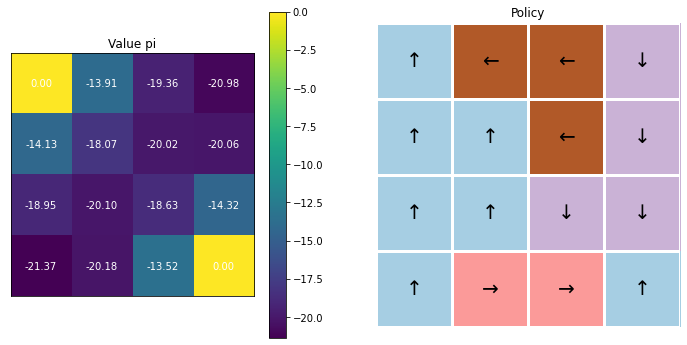

In [7]:
#v_pi = dp_agent.policy_evaluation()
fig, ax = plt.subplots(1,2, figsize=(12,6))
visualize_value_function(ax[0], mc_agent.v, nx, ny)
_ = ax[0].set_title("Value pi")
visualize_policy(ax[1], mc_agent._policy_q, nx, ny)
_ = ax[1].set_title("Policy")

In [8]:
mc_agent.epsilon *= 0.5

In [9]:
for _ in range(1000):
    run_episode(env, mc_agent)

In [10]:
mc_agent.improve_policy()

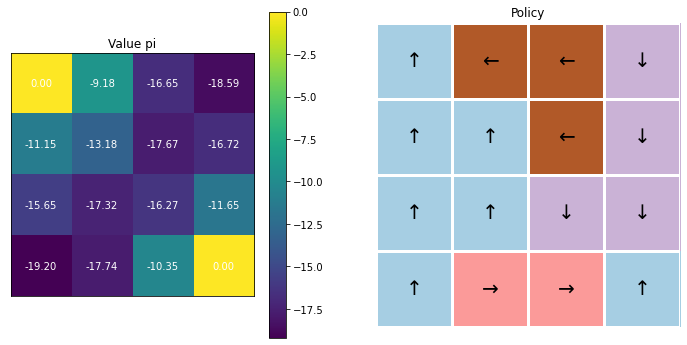

In [11]:
#v_pi = dp_agent.policy_evaluation()
fig, ax = plt.subplots(1,2, figsize=(12,6))
visualize_value_function(ax[0], mc_agent.v, nx, ny)
_ = ax[0].set_title("Value pi")
visualize_policy(ax[1], mc_agent._policy_q, nx, ny)
_ = ax[1].set_title("Policy")

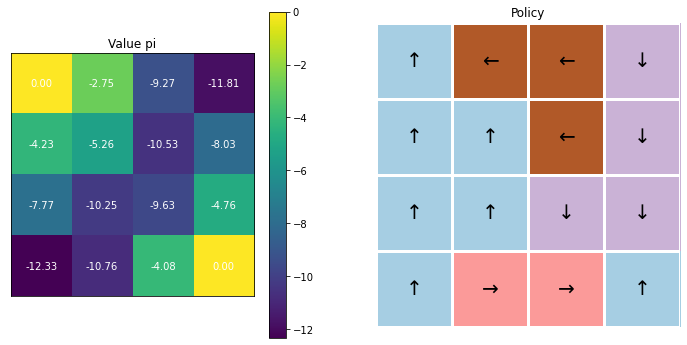

In [12]:
mc_agent.epsilon *= 0.9
for _ in range(5000):
    run_episode(env, mc_agent)
mc_agent.improve_policy()
#v_pi = dp_agent.policy_evaluation()
fig, ax = plt.subplots(1,2, figsize=(12,6))
visualize_value_function(ax[0], mc_agent.v, nx, ny)
_ = ax[0].set_title("Value pi")
visualize_policy(ax[1], mc_agent._policy_q, nx, ny)
_ = ax[1].set_title("Policy")

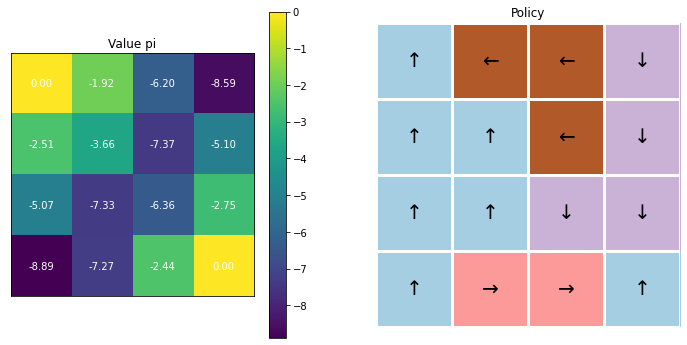

In [13]:
mc_agent.epsilon *= 0.9
for _ in range(5000):
    run_episode(env, mc_agent)
mc_agent.improve_policy()
#v_pi = dp_agent.policy_evaluation()
fig, ax = plt.subplots(1,2, figsize=(12,6))
visualize_value_function(ax[0], mc_agent.v, nx, ny)
_ = ax[0].set_title("Value pi")
visualize_policy(ax[1], mc_agent._policy_q, nx, ny)
_ = ax[1].set_title("Policy")

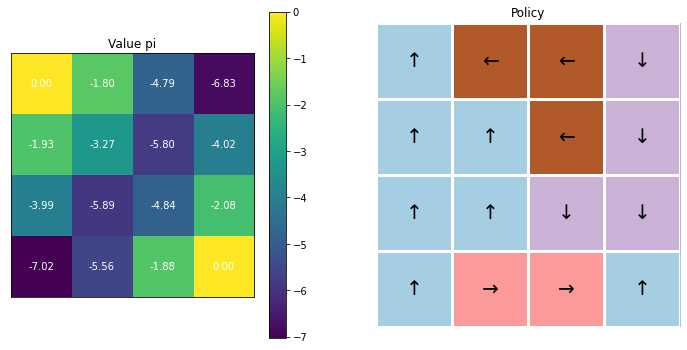

In [14]:
mc_agent.epsilon *= 0.9
for _ in range(5000):
    run_episode(env, mc_agent)
mc_agent.improve_policy()
#v_pi = dp_agent.policy_evaluation()
fig, ax = plt.subplots(1,2, figsize=(12,6))
visualize_value_function(ax[0], mc_agent.v, nx, ny)
_ = ax[0].set_title("Value pi")
visualize_policy(ax[1], mc_agent._policy_q, nx, ny)
_ = ax[1].set_title("Policy")

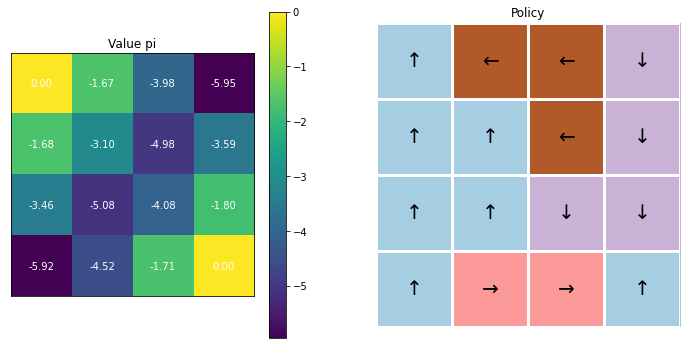

In [15]:
mc_agent.epsilon *= 0.9
for _ in range(5000):
    run_episode(env, mc_agent)
mc_agent.improve_policy()
#v_pi = dp_agent.policy_evaluation()
fig, ax = plt.subplots(1,2, figsize=(12,6))
visualize_value_function(ax[0], mc_agent.v, nx, ny)
_ = ax[0].set_title("Value pi")
visualize_policy(ax[1], mc_agent._policy_q, nx, ny)
_ = ax[1].set_title("Policy")

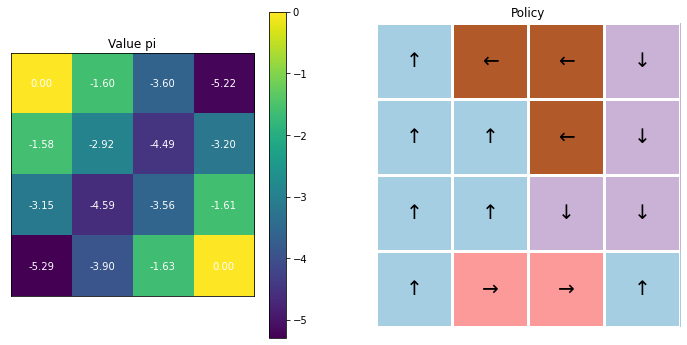

In [16]:
mc_agent.epsilon *= 0.9
for _ in range(5000):
    run_episode(env, mc_agent)
mc_agent.improve_policy()
#v_pi = dp_agent.policy_evaluation()
fig, ax = plt.subplots(1,2, figsize=(12,6))
visualize_value_function(ax[0], mc_agent.v, nx, ny)
_ = ax[0].set_title("Value pi")
visualize_policy(ax[1], mc_agent._policy_q, nx, ny)
_ = ax[1].set_title("Policy")

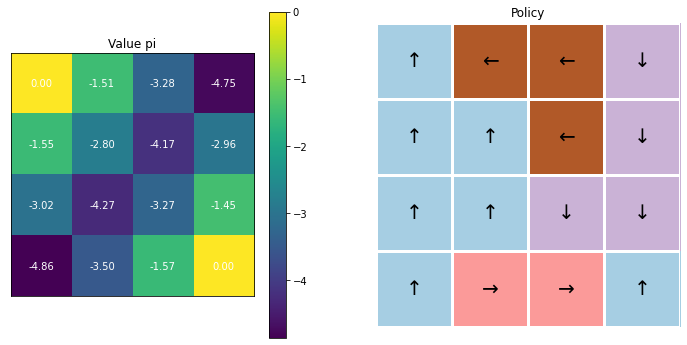

In [17]:
mc_agent.epsilon *= 0.9
for _ in range(5000):
    run_episode(env, mc_agent)
mc_agent.improve_policy()
#v_pi = dp_agent.policy_evaluation()
fig, ax = plt.subplots(1,2, figsize=(12,6))
visualize_value_function(ax[0], mc_agent.v, nx, ny)
_ = ax[0].set_title("Value pi")
visualize_policy(ax[1], mc_agent._policy_q, nx, ny)
_ = ax[1].set_title("Policy")

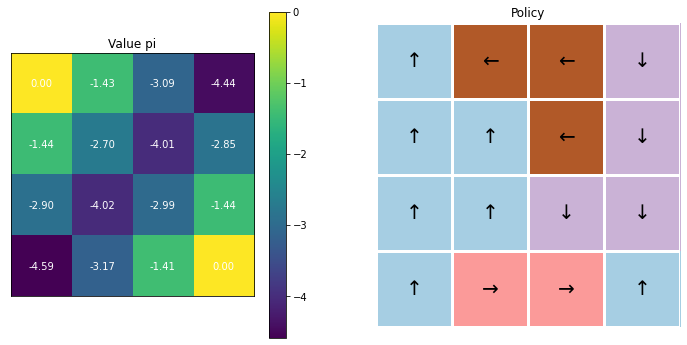

In [18]:
mc_agent.epsilon *= 0.9
for _ in range(5000):
    run_episode(env, mc_agent)
mc_agent.improve_policy()
#v_pi = dp_agent.policy_evaluation()
fig, ax = plt.subplots(1,2, figsize=(12,6))
visualize_value_function(ax[0], mc_agent.v, nx, ny)
_ = ax[0].set_title("Value pi")
visualize_policy(ax[1], mc_agent._policy_q, nx, ny)
_ = ax[1].set_title("Policy")

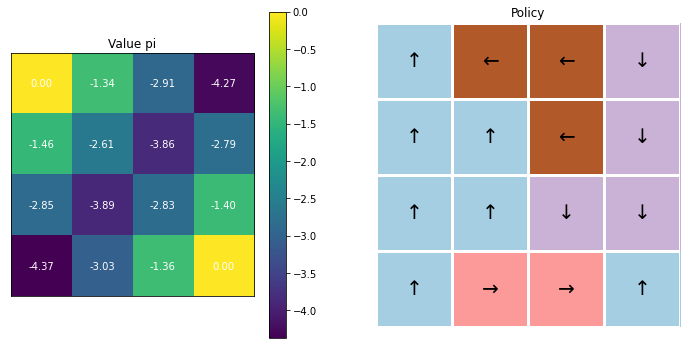

In [19]:
mc_agent.epsilon *= 0.9
for _ in range(5000):
    run_episode(env, mc_agent)
mc_agent.improve_policy()
#v_pi = dp_agent.policy_evaluation()
fig, ax = plt.subplots(1,2, figsize=(12,6))
visualize_value_function(ax[0], mc_agent.v, nx, ny)
_ = ax[0].set_title("Value pi")
visualize_policy(ax[1], mc_agent._policy_q, nx, ny)
_ = ax[1].set_title("Policy")

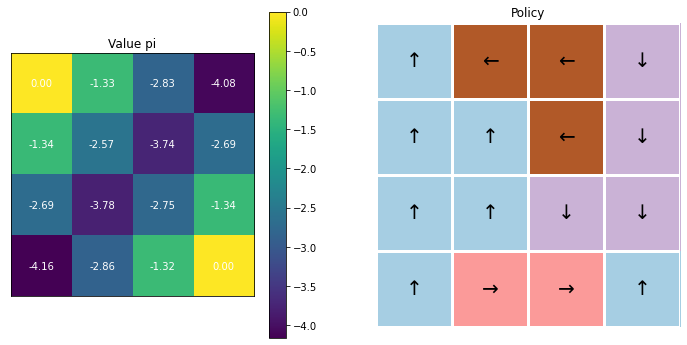

In [20]:
mc_agent.epsilon *= 0.9
for _ in range(5000):
    run_episode(env, mc_agent)
mc_agent.improve_policy()
#v_pi = dp_agent.policy_evaluation()
fig, ax = plt.subplots(1,2, figsize=(12,6))
visualize_value_function(ax[0], mc_agent.v, nx, ny)
_ = ax[0].set_title("Value pi")
visualize_policy(ax[1], mc_agent._policy_q, nx, ny)
_ = ax[1].set_title("Policy")

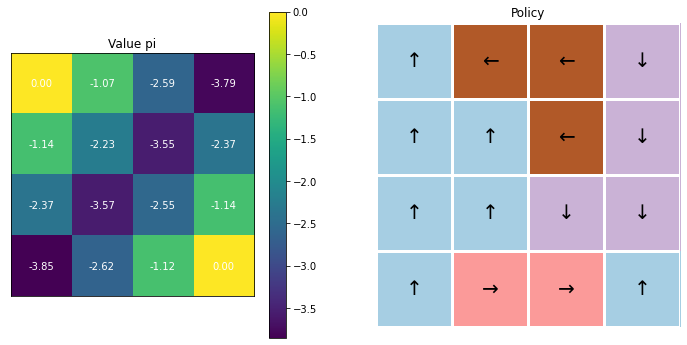

In [21]:
mc_agent.epsilon *= 0.01
for _ in range(5000):
    run_episode(env, mc_agent)
mc_agent.improve_policy()
#v_pi = dp_agent.policy_evaluation()
fig, ax = plt.subplots(1,2, figsize=(12,6))
visualize_value_function(ax[0], mc_agent.v, nx, ny)
_ = ax[0].set_title("Value pi")
visualize_policy(ax[1], mc_agent._policy_q, nx, ny)
_ = ax[1].set_title("Policy")